<a href="https://colab.research.google.com/github/Abdallah-RA/HyperRA-/blob/main/HyperRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install onnx requests tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 97.3 MB/s eta 0:00:00


AlexNet: 100%|██████████| 244M/244M [00:03<00:00, 65.3MB/s]
ERROR:downloader:DenseNet121 failed: 404 Client Error: Not Found for url: https://github.com/onnx/models/raw/main/validated/vision/classification/densenet-121/model/densenet-121.onnx
ERROR:downloader:GoogLeNet failed: 404 Client Error: Not Found for url: https://github.com/onnx/models/raw/main/validated/vision/classification/googlenet/model/googlenet-9.onnx
ERROR:downloader:InceptionV1 failed: 404 Client Error: Not Found for url: https://github.com/onnx/models/raw/main/validated/vision/classification/inception_and_resnet/inception-v1/model/inception-v1-12.onnx
ERROR:downloader:MobileNetV2 failed: 404 Client Error: Not Found for url: https://github.com/onnx/models/raw/main/validated/vision/classification/mobilenet/model/mobilenetv2-1.0.onnx
ResNet18: 100%|██████████| 46.8M/46.8M [00:00<00:00, 82.5MB/s]
ResNet50: 100%|██████████| 103M/103M [00:01<00:00, 81.5MB/s] 
ShuffleNet: 100%|██████████| 9.22M/9.22M [00:00<00:00, 54.1MB/s]


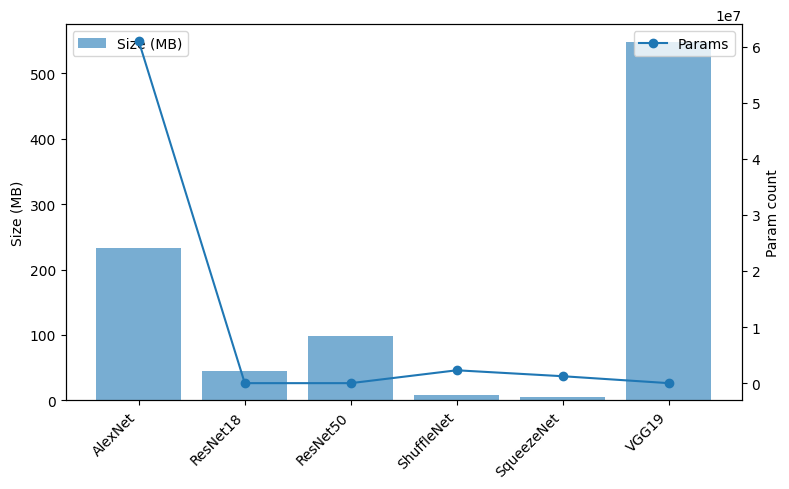

In [4]:
# ─── ENSURE DEPENDENCIES ───────────────────────────────────────────
import subprocess
import sys

def ensure_package(pkg_name: str):
    try:
        __import__(pkg_name)
    except ImportError:
        print(f"Installing {pkg_name}…")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])

for pkg in ("onnx", "requests", "tqdm"):
    ensure_package(pkg)

# ─── ACTUAL SCRIPT ─────────────────────────────────────────────────
import logging
from pathlib import Path
from typing import List, Dict

import requests
import onnx
from tqdm import tqdm

# ─── CONFIG ────────────────────────────────────────────────────────
OUT_DIR = Path("onnx_models")
OUT_DIR.mkdir(exist_ok=True)

MODELS: List[Dict[str, str]] = [
    {
        "name": "AlexNet",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/alexnet/model/bvlcalexnet-3.onnx"
    },
    {
        "name": "DenseNet121",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/densenet-121/model/densenet-121.onnx"
    },
    {
        "name": "GoogLeNet",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/googlenet/model/googlenet-9.onnx"
    },
    {
        "name": "InceptionV1",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/inception_and_resnet/inception-v1/model/inception-v1-12.onnx"
    },
    {
        "name": "MobileNetV2",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/mobilenet/model/mobilenetv2-1.0.onnx"
    },
    {
        "name": "ResNet18",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/resnet/model/resnet18-v1-7.onnx"
    },
    {
        "name": "ResNet50",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/resnet/model/resnet50-v1-12.onnx"
    },
    {
        "name": "ShuffleNet",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/shufflenet/model/shufflenet-v2-10.onnx"
    },
    {
        "name": "SqueezeNet",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/squeezenet/model/squeezenet1.0-7.onnx"
    },
    {
        "name": "VGG19",
        "url": "https://github.com/onnx/models/raw/main/validated/vision/classification/vgg/model/vgg19-7.onnx"
    },
]

# ─── LOGGER ────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S",
)
log = logging.getLogger("downloader")

# ─── HELPERS ───────────────────────────────────────────────────────
def download(name: str, url: str) -> Path:
    out = OUT_DIR / f"{name}.onnx"
    if out.exists():
        log.info(f"{name} already downloaded.")
        return out

    log.info(f"Downloading {name}...")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    total = int(resp.headers.get("content-length", 0))
    with open(out, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=name) as bar:
        for chunk in resp.iter_content(1024):
            f.write(chunk)
            bar.update(len(chunk))
    return out

def analyze(path: Path) -> Dict[str, float]:
    model = onnx.load(str(path))
    byte_count = sum(init.raw_data.__len__() for init in model.graph.initializer)
    return {
        "params": byte_count / 4,
        "size_mb": path.stat().st_size / (1024 ** 2),
    }

# ─── MAIN ─────────────────────────────────────────────────────────
def main():
    stats = []
    for m in MODELS:
        try:
            p = download(m["name"], m["url"])
            info = analyze(p)
            stats.append((m["name"], info["params"], info["size_mb"]))
            log.info(f"{m['name']}: {info['params']:.1e} params, {info['size_mb']:.2f} MB")
        except Exception as e:
            log.error(f"{m['name']} failed: {e}")

    if not stats:
        log.error("No models succeeded, exiting.")
        return

    # Plot results (optional)
    try:
        import matplotlib.pyplot as plt
        names, params, sizes = zip(*stats)
        fig, ax1 = plt.subplots(figsize=(8, 5))
        ax2 = ax1.twinx()
        ax1.bar(names, sizes, alpha=0.6, label="Size (MB)")
        ax2.plot(names, params, marker="o", label="Params")
        ax1.set_xticklabels(names, rotation=45, ha="right")
        ax1.set_ylabel("Size (MB)")
        ax2.set_ylabel("Param count")
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
    except ImportError:
        log.info("matplotlib not installed; skipping plot.")

if __name__ == "__main__":
    main()
